In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.registrationdata as regdata
import defmod.optimize
from defmod.attachement import L2NormAttachement
from defmod.energyfunctional import EnergyFunctional_unconstrained, EnergyFunctional
import scipy.optimize
import defmod.save_results as results


torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
data = regdata.organs()
data.build_modules()
data()
source = data.source
target = data.target

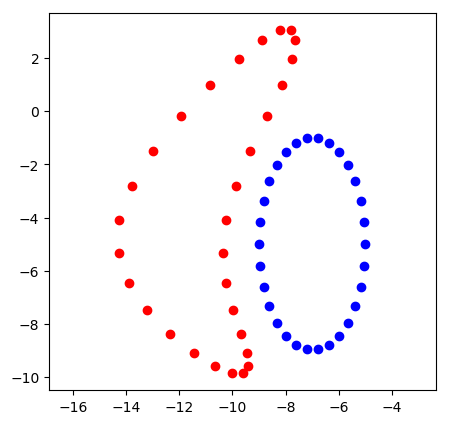

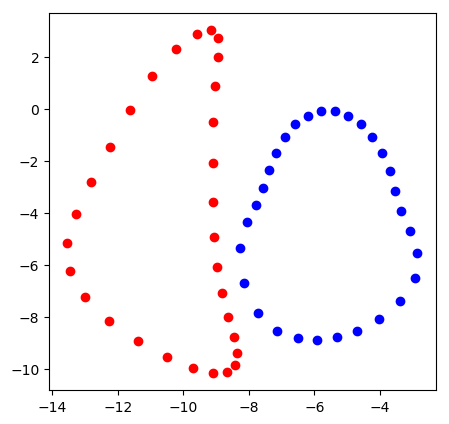

In [37]:
figsize = (5,5)
dpi = 100

fig_source = plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

fig_target = plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

#plt.axis('equal')
plt.show()

In [3]:
modules = dm.multishape.MultiShapeModule([data.modules[0], data.modules[1]], 0.5)
modules.fill_controls_zero()
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [4]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
E = EnergyFunctional(modules, H, constr_Id, source, target, 2, reg_param)
X = [gd0_tensor, mom0_tensor]

In [5]:
X[1] = dm.optimize.BFGS(E, X)(maxiter=50)

cost: [ 0.] attach: 16.183242198688024
cost: [ 0.] attach: 16.183242198688024
cost: [ 0.0029091] attach: 13.418319610402868
cost: [ 0.0029091] attach: 13.418319610402868
cost: [ 0.02742648] attach: 9.43637422217381
cost: [ 0.02742648] attach: 9.43637422217381
cost: [ 0.0346493] attach: 8.976562564554893
cost: [ 0.0346493] attach: 8.976562564554893
cost: [ 0.04575745] attach: 8.07880254335411
cost: [ 0.04575745] attach: 8.07880254335411
cost: [ 0.14461368] attach: 5.088276280088405
cost: [ 0.14461368] attach: 5.088276280088405
cost: [ 0.69380674] attach: 12.599405133442122
cost: [ 0.69380674] attach: 12.599405133442122
cost: [ 0.20448184] attach: 4.467814033386029
cost: [ 0.20448184] attach: 4.467814033386029
cost: [ 0.17889973] attach: 3.610241619345031
cost: [ 0.17889973] attach: 3.610241619345031
cost: [ 0.17913991] attach: 3.5085243921655818
cost: [ 0.17913991] attach: 3.5085243921655818
cost: [ 0.18048] attach: 3.337016722829638
cost: [ 0.18048] attach: 3.337016722829638
cost: [ 0.

In [11]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
H.geodesic_controls()
save = results.Save_Results_MultiShape(H, source, target)

xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)

#fig_states = save.fig_states(show=True)
#fig_grid1, fig_grid2, fig_grid_bg, fig_multigrid = save.fig_grids(True)

save.save('../results/moving_organs/MultiShapeDefmod/')
plt.close('all')

In [33]:
## LDDMM Module

man_compound = dm.manifold.Landmarks(2, len(source[0])+len(source[1]), gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man_compound, sigma=0.5)])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

def attach(module, target):
    p = module.manifold[0].gd.view(-1,2)
    return dm.attachement.L2NormAttachement()(p, torch.cat(target))

Energy_LDDMM = EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, [torch.cat(source)], [torch.cat(target)], dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

X_LDDMM[1] = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=250)

cost: 0.0 attach: 11.62071023450843
cost: 0.0 attach: 11.62071023450843
cost: 0.00109959654454 attach: 9.776700172422784
cost: 0.00109959654454 attach: 9.776700172422784
cost: 0.0274899136135 attach: 5.810180608405568
cost: 0.0274899136135 attach: 5.810180608405568
cost: 0.0374047141791 attach: 3.989301934961564
cost: 0.0374047141791 attach: 3.989301934961564
cost: 0.047815277777 attach: 2.4517549478074843
cost: 0.047815277777 attach: 2.4517549478074843
cost: 0.0374496118773 attach: 1.2906082254234157
cost: 0.0374496118773 attach: 1.2906082254234157
cost: 0.0398971600851 attach: 2.4552237015628116
cost: 0.0398971600851 attach: 2.4552237015628116
cost: 0.0374681107954 attach: 0.8823460314506071
cost: 0.0374681107954 attach: 0.8823460314506071
cost: 0.0406341752936 attach: 0.638807556628834
cost: 0.0406341752936 attach: 0.638807556628834
cost: 0.0426071662407 attach: 0.43805165041772787
cost: 0.0426071662407 attach: 0.43805165041772787
cost: 0.0424359459897 attach: 0.4640960035617222
cos

cost: 0.0412155121902 attach: 0.0017741640445937841
cost: 0.0412153995059 attach: 0.001708849763537205
cost: 0.0412153995059 attach: 0.001708849763537205
cost: 0.0412154221942 attach: 0.0016374584938110995
cost: 0.0412154221942 attach: 0.0016374584938110995
cost: 0.0412155366663 attach: 0.0015453184853431738
cost: 0.0412155366663 attach: 0.0015453184853431738
cost: 0.0412157753332 attach: 0.001497240696292456
cost: 0.0412157753332 attach: 0.001497240696292456
cost: 0.041215830481 attach: 0.0014340460274610985
cost: 0.041215830481 attach: 0.0014340460274610985
cost: 0.0412160753343 attach: 0.001347071286084066
cost: 0.0412160753343 attach: 0.001347071286084066
cost: 0.0412161705653 attach: 0.0013080528970426494
cost: 0.0412161705653 attach: 0.0013080528970426494
cost: 0.0412159820168 attach: 0.0012496762169438135
cost: 0.0412159820168 attach: 0.0012496762169438135
cost: 0.0412157221703 attach: 0.0011950962074664764
cost: 0.0412157221703 attach: 0.0011950962074664764
cost: 0.041215297868

cost: 0.0412138241084 attach: 0.00012027540611662295
cost: 0.0412137956036 attach: 0.00011569552003180117
cost: 0.0412137956036 attach: 0.00011569552003180117
cost: 0.0412137922568 attach: 0.00010991781891783237
cost: 0.0412137922568 attach: 0.00010991781891783237
cost: 0.0412138161009 attach: 0.0001069538043549756
cost: 0.0412138161009 attach: 0.0001069538043549756
cost: 0.0412137929878 attach: 0.00010241890868585472
cost: 0.0412137929878 attach: 0.00010241890868585472
cost: 0.0412137921908 attach: 9.708972001393649e-05
cost: 0.0412137921908 attach: 9.708972001393649e-05
cost: 0.0412137785506 attach: 9.225435744230933e-05
cost: 0.0412137785506 attach: 9.225435744230933e-05
cost: 0.0412137717249 attach: 8.814634823699258e-05
cost: 0.0412137717249 attach: 8.814634823699258e-05
cost: 0.0412137611097 attach: 8.320884503647929e-05
cost: 0.0412137611097 attach: 8.320884503647929e-05
cost: 0.0412137544358 attach: 8.43085120704704e-05
cost: 0.0412137544358 attach: 8.43085120704704e-05
cost: 0

cost: 0.0412136822225 attach: 1.5785511145036906e-06
cost: 0.0412136815208 attach: 1.535232344148212e-06
cost: 0.0412136815208 attach: 1.535232344148212e-06
cost: 0.0412136818493 attach: 1.4719192907157923e-06
cost: 0.0412136818493 attach: 1.4719192907157923e-06
cost: 0.0412136820515 attach: 1.3956223739168553e-06
cost: 0.0412136820515 attach: 1.3956223739168553e-06
cost: 0.0412136821894 attach: 1.3278781584143975e-06
cost: 0.0412136821894 attach: 1.3278781584143975e-06
cost: 0.0412136821078 attach: 1.2624111604908831e-06
cost: 0.0412136821078 attach: 1.2624111604908831e-06
cost: 0.0412136815827 attach: 1.1999877397706755e-06
cost: 0.0412136815827 attach: 1.1999877397706755e-06
cost: 0.041213681786 attach: 1.1468614947400102e-06
cost: 0.041213681786 attach: 1.1468614947400102e-06
cost: 0.0412136818811 attach: 1.1384977074303571e-06
cost: 0.0412136818811 attach: 1.1384977074303571e-06
cost: 0.0412136819821 attach: 1.1237470153742805e-06
cost: 0.0412136819821 attach: 1.1237470153742805e-

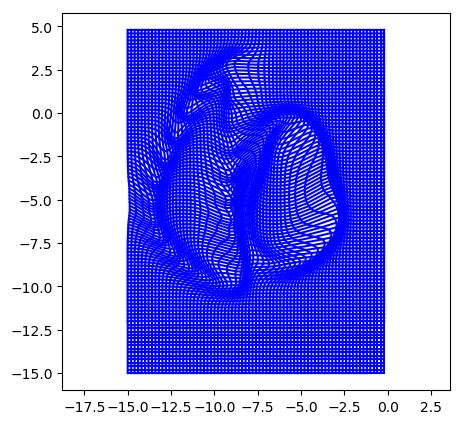

In [36]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target)

xlim = [-15, 0]
ylim = [-15, 5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

save.save('../results/moving_organs/LDDMM/')
plt.close('all')

In [40]:
## LDDMM Multishape Module
dim = 2
nb_pts1 = len(source[0])
nb_pts2 = len(source[1])
sigma1 = 2
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
mod1 = dm.deformationmodules.CompoundModule([trans1])

sigma2 = 2
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, 5.)
mod2 = dm.deformationmodules.CompoundModule([trans2])

module_list = [mod1, mod2]
sigma_bg = 0.5
multi_LDDMM = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [48]:
constr = dm.constraints.Identity_Silent()
H_multi_LDDMM = dm.hamiltonian_multishape.Hamiltonian_multi(multi_LDDMM, constr)

def attach(modules, target):
    return sum([L2NormAttachement()( modules.module_list[i][0].manifold.gd, target[i]) for i in range(len(target))])
    
Energy_multi_LDDMM = EnergyFunctional(multi_LDDMM, H_multi_LDDMM, constr, source, target, dim=2, gamma=reg_param, attach = attach)
gd0 = torch.cat(multi_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(multi_LDDMM.manifold.unroll_cotan())
X_multi_LDDMM = [gd0, mom0]


X_multi_LDDMM[1] = dm.optimize.BFGS(Energy_multi_LDDMM, X_multi_LDDMM, disp=True)(maxiter=20)

cost: 0.0 attach: 16.183242198688024
cost: 0.0 attach: 16.183242198688024
cost: 1.64560217629e+67 attach: 1.0262482120944094e+35
cost: 1.64560217629e+67 attach: 1.0262482120944094e+35
cost: 1.6702310327e-198 attach: 16.183242198688024
cost: 1.6702310327e-198 attach: 16.183242198688024
cost: 1.6702310327e-198 attach: 16.183242198688024
cost: 1.6702310327e-198 attach: 16.183242198688024
cost: 1.64560217629e+67 attach: 1.0262482120944094e+35
cost: 1.03515731197e+64 attach: 2.573908855530955e+33
cost: 1.09420485477e+62 attach: 2.6463013944936258e+32
cost: 4.93862411294e+56 attach: 5.622027598904547e+29
cost: 3.31474319159e+56 attach: 4.605904517698468e+29
cost: 1.21149559364e+52 attach: 2.7845236216099186e+27
cost: 1.10599699845e+55 attach: 8.41331135171077e+28
cost: 1.35400240203e+44 attach: 2.9437417300031276e+23
cost: 8.1763668715e+47 attach: 2.129678439935811e+25
cost: 1.02759838177e+64 attach: 2.2439322785340747e+33
cost: 1.04002565524e+77 attach: 7.138715368115291e+39
cost: 4.9611506

In [ ]:
H_multi_LDDMM.module.manifold.fill_gd(X_multi_LDDMM[0])
H_multi_LDDMM.module.manifold.fill_cotan(X_multi_LDDMM[1])
H_multi_LDDMM.geodesic_controls()
save = results.Save_Results_MultiShape(H_multi_LDDMM, source, target)

xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
#save.fig_grids(True)

save.save('../results/moving_organs/MultiShapeLDDMM/')
plt.close('all')

In [55]:
## Unconstrained Compound Module


module_compound = dm.deformationmodules.CompoundModule(data.modules)
H_compound = dm.hamiltonian.Hamiltonian(module_compound)

def attach(modules, target):
    return sum([L2NormAttachement()(data.modules[i][0].manifold.gd, target[i]) for i in range(len(target))])
Energy_compound = EnergyFunctional_unconstrained(module_compound, H_compound, source, target, dim=2, gamma=reg_param, attach=attach)
gd0_c = torch.cat(module_compound.manifold.unroll_gd())
mom0_c = torch.cat(module_compound.manifold.unroll_cotan())
X_compound = [gd0_c, mom0_c]

X_compound[1] = dm.optimize.BFGS(Energy_compound, X_compound, disp=True)(maxiter=20)

cost: [ 0.] attach: 16.183242198688024
cost: [ 0.] attach: 16.183242198688024
cost: [ 0.08029161] attach: 16.183242198688024
cost: [ 0.08029161] attach: 16.183242198688024
cost: [ 0.00890654] attach: 16.183242198688024
cost: [ 0.00890654] attach: 16.183242198688024
cost: [ 0.00098907] attach: 16.183242198688024
cost: [ 0.00098907] attach: 16.183242198688024
cost: [ 0.00010988] attach: 16.183242198688024
cost: [ 0.00010988] attach: 16.183242198688024
cost: [  1.22077556e-05] attach: 16.183242198688024
cost: [  1.22077556e-05] attach: 16.183242198688024
cost: [  1.35638959e-06] attach: 16.183242198688024
cost: [  1.35638959e-06] attach: 16.183242198688024
cost: [  1.50708929e-07] attach: 16.183242198688024
cost: [  1.50708929e-07] attach: 16.183242198688024
cost: [  1.67453986e-08] attach: 16.183242198688024
cost: [  1.67453986e-08] attach: 16.183242198688024
cost: [  1.86059844e-09] attach: 16.183242198688024
cost: [  1.86059844e-09] attach: 16.183242198688024
cost: [  2.06733108e-10] a

In [56]:
H_compound.module.manifold.fill_gd(X_compound[0])
H_compound.module.manifold.fill_cotan(X_compound[1])
H_compound.geodesic_controls()
save = results.Save_Results_SingleShape(H_compound, source, target)

xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
#fig = save.fig_grid(True)

save.save('../results/moving_organs/Compound/')
plt.close('all')

In [29]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = 1000*torch.rand(mom0_tensor.shape)


test_gradcheck_Hamiltonian()

True